In [ ]:
# test oop methods one by one

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
#from tensorflow.python.framework.ops import EagerTensor


In [ ]:
!git clone https://github.com/mohamedamine99/Neural-Style-Transfer-with-Python.git

fatal: destination path 'Neural-Style-Transfer-with-Python' already exists and is not an empty directory.


In [8]:
class NST_creator():
    def __init__(self, base_model = None, input_shape = (400, 400, 3),
                 content_layer_name = None, style_layer_names = None,
                 style_layer_weights = None, verbose = True ):

        self.input_shape = input_shape

        if content_layer_name == None:
            self.content_layer_name = 'block2_conv2'
        else:
            self.content_layer_name = content_layer_name

        if style_layer_names == None:
            self.style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                                            'block4_conv1', 'block5_conv1']
        else:
            self.style_layer_names = style_layer_names


        if style_layer_weights == None:
            self.style_layer_weights = [1 for layer in style_layer_names]
        else:
            self.style_layer_weights = style_layer_weights


        if base_model != None:
            self.base_model = base_model
            self.base_model.trainable = False

        else :
            print('Loading VGG19 Model from Keras applications ...')
            self.base_model = VGG19(input_shape = input_shape, include_top= False, weights = 'imagenet')
            self.base_model.trainable = False

        self.content_model = self.create_content_model(content_layer_name)
        self.style_model = self.create_style_model(style_layer_names)
        if verbose:
            print('='* 10)
            print(f'BASE MODEL NAME : {self.base_model.name}')
            print(f'INPUT SHAPE : {self.input_shape}')
            print(f'CONTENT OUTPUT LAYER : {self.content_layer_name}')
            print(f'STYLE OUTPUT LAYERS : {self.style_layer_names}')
            print(f'STYLE LAYER WEIGHTS : {self.style_layer_weights}')



    def create_content_model(self, content_layer_name):

        content_model = Model(inputs = [self.base_model.input], outputs = [self.base_model.get_layer(content_layer_name).output])

        return content_model


    def create_style_model(self, style_layer_names):

        outputs = [self.base_model.get_layer(layer_name).output for layer_name in style_layer_names]
        style_model = Model(inputs = [self.base_model.input], outputs = outputs)

        return style_model

    @staticmethod
    def compute_content_cost(content_activations, generated_activations):
        cost = tf.reduce_mean(tf.square(content_activations - generated_activations)) / 4
        return cost

    @staticmethod
    def compute_gram(A):

        gram = tf.matmul(A , tf.transpose(A))
        return gram

    @staticmethod
    def compute_layer_style_cost(style_activation, generated_activation):

        # get shapes
        #print(style_activation.shape)
        height, width, channels = style_activation.shape[-3:]
        # unroll and reshape and transpose activations , have them have the following shape (nc, n_h*n_w) : (channels, height * width)
        # prepare them to calculate gram matrices
        a_s_unrolled = tf.transpose(tf.reshape(style_activation, shape = [-1, channels]))
        a_g_unrolled = tf.transpose(tf.reshape(generated_activation, shape = [-1, channels]))

        # compute style and generated GRAM matrices
        gram_g = compute_gram(a_g_unrolled)
        gram_s = compute_gram(a_s_unrolled)

        layer_cost = tf.reduce_sum(tf.square(gram_s - gram_g)) / (2 * channels * height * width) ** 2
        return layer_cost


    @staticmethod
    def compute_style_cost(style_activations = None, generated_activations = None, layer_weights = None):

        style_cost = 0
        if layer_weights == None:
            layer_weights = [1 for layer in style_activations]

        #print(f'{layer_weights=}')
        for i, (style_activation, generated_activation, weight) in enumerate(zip(style_activations, generated_activations, layer_weights)):

            #print(f'Style Layer index : -{i}- ')#, end = ' ')
            layer_style_cost = compute_layer_style_cost(style_activation, generated_activation)
            style_cost += weight * layer_style_cost

        return style_cost

    @staticmethod
    @tf.function()
    def compute_total_cost(content_cost, style_cost, alpha = 10, beta = 40):
        return alpha * content_cost + beta * style_cost

    @staticmethod
    def preprocess_img(img, img_size = (400, 400)):

        resized_image =  cv2.resize(img, img_size)
        tensor_image = tf.constant(np.reshape(resized_image, ((1,) + content_image.shape)))
        tensor_image = tf.image.convert_image_dtype(tensor_image, tf.float32)
        return tensor_image

    @staticmethod
    def generated_img_init(content_img):
        generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
        noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
        generated_image = tf.add(generated_image, noise)
        generated_image_preprocessed = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
        generated_image_preprocessed = tf.Variable(generated_image_preprocessed, tf.float32)

        return generated_image_preprocessed

    # add static method clip0_1 image
    @staticmethod
    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

   # check the train loop args and implemenation, possible one step method implementations
    def train_loop(self, content_img, style_img, epochs = 15000, learning_rate = 10e-3, save_dir = None):

        # inputs initializations: content, style and generated images
        img_size = (self.input_shape[0],  self.input_shape[1])

        content_img_preprocessed = self.preprocess_img(content_img, img_size = img_size)
        style_img_preprocessed = self.preprocess_img(style_img, img_size = img_size)
        generated_image_preprocessed = self.generated_img_init(content_img)

        # initialize content and style models
        c_m = self.create_content_model( content_layer_name = self.content_layer_name)
        s_m = self.create_style_model(style_layer_names = self.style_layer_names)

        # initialize activations of content and style models
        a_c = c_m(content_img_preprocessed)
        a_s = s_m(style_img_preprocessed)

        # initialize optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        beg = time.time()
        for i in range(epochs):

            with tf.GradientTape() as tape:
                # generated activations here generated_img
                a_g = c_m(generated_image_preprocessed)
                content_cost = compute_content_cost(a_c, a_g)

                a_g = s_m(generated_image_preprocessed)
                style_cost = compute_style_cost(a_s, a_g, layer_weights = None)

                cost = compute_total_cost(content_cost, style_cost, alpha = 100, beta = 100)
                #print(f'--Cost = {float(cost.numpy())}', end =' ')


            grads = tape.gradient(cost, generated_image_preprocessed)
            optimizer.apply_gradients([(grads, generated_image_preprocessed)])
            if i % 1000 == 0:

                print(f'Epoch : {i} -- Cost = {float(cost.numpy())}')
            # add 0_1 clipping here
            generated_image_preprocessed.assign(clip_0_1(generated_image_preprocessed))

        # bgr display
        plt.imshow(generated_image_preprocessed[0].numpy())
        end = time.time()
        print(f'Compute time {end - beg} s')
        return generated_image_preprocessed[0].numpy()





In [3]:
nst = NST_creator()

Loading VGG19 Model from Keras applications ...
80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# TODO : try adding brackets
def create_content_model(model = None, layer_name = None, layer_index = None):

    content_model = Model(inputs = [model.input], outputs = [model.get_layer(layer_name).output])

    return content_model

In [ ]:
# TODO : try adding brackets
def create_style_model(model = None, layer_names = None):
    outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    style_model = Model(inputs = [model.input], outputs = outputs)
    return style_model

In [ ]:
# TODO : chack activations
# content_cost value OK
# ----- OK -------

def compute_content_cost(content_activations, generated_activations):
    # Add a preprocess imgs for content and generated here
    #...

    # get the content image & generated img activations
    #a_c = content_model(content_img)
    #a_g = content_model(generated_img)

    cost = tf.reduce_mean(tf.square(content_activations - generated_activations)) / 4

    return cost



In [ ]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
print(J_content)

tf.Tensor(7.056877, shape=(), dtype=float32)


In [ ]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = tf.reduce_mean(tf.square(a_C - a_G)) / 4
print(J_content)

tf.Tensor(7.056877, shape=(), dtype=float32)


In [ ]:
# V2 changed calculate_gram
# A already unrolled
# TODO: check if ok with values comparison
# ----- OK -------
def compute_gram(A):

    gram = tf.matmul(A , tf.transpose(A))
    #print(gram.shape)
    return gram

In [ ]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
print(A.shape)
print(compute_gram(A))

(3, 2)
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


In [ ]:
# change whole formula :
# args = style_activations and generated_activations : tensors
# Unroll tensors and transpose then calculate gram
# --------- OK -------------
def compute_layer_style_cost(style_activation, generated_activation):

    # get shapes
    #print(style_activation.shape)
    height, width, channels = style_activation.shape[-3:]
    # unroll and reshape and transpose activations , have them have the following shape (nc, n_h*n_w) : (channels, height * width)
    # prepare them to calculate gram matrices
    a_s_unrolled = tf.transpose(tf.reshape(style_activation, shape = [-1, channels]))
    a_g_unrolled = tf.transpose(tf.reshape(generated_activation, shape = [-1, channels]))

    # compute style and generated GRAM matrices
    gram_g = compute_gram(a_g_unrolled)
    gram_s = compute_gram(a_s_unrolled)

    layer_cost = tf.reduce_sum(tf.square(gram_s - gram_g)) / (2 * channels * height * width) ** 2
    return layer_cost


In [ ]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
#J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)
print(J_style_layer_SG)

tf.Tensor(14.017805, shape=(), dtype=float32)


In [ ]:
# TODO rethink whole function structure
# TODO check numeric values
def compute_style_cost(style_activations = None, generated_activations = None, layer_weights = None):

    style_cost = 0
    if layer_weights == None:
        layer_weights = [1 for layer in style_activations]

    #print(f'{layer_weights=}')
    for i, (style_activation, generated_activation, weight) in enumerate(zip(style_activations, generated_activations, layer_weights)):

        #print(f'Style Layer index : -{i}- ')#, end = ' ')
        layer_style_cost = compute_layer_style_cost(style_activation, generated_activation)
        style_cost += weight * layer_style_cost

    return style_cost


In [ ]:
tf.random.set_seed(1)
a_S = tf.random.normal([5, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([5, 4, 4, 3], mean=1, stddev=4)
compute_style_cost( a_S, a_G , layer_weights = None)

<tf.Tensor: shape=(), dtype=float32, numpy=67.39638>

In [ ]:
# TODO test values and compare
# ------- OK ----------
@tf.function()
def compute_total_cost(content_cost, style_cost, alpha = 10, beta = 40):
    return alpha * content_cost + beta * style_cost


In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
J_content = 0.2
J_style = 0.8
J = compute_total_cost(J_content, J_style)
np.random.seed(1)
print("J = " + str(compute_total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))
print(J)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
tf.Tensor(34.0, shape=(), dtype=float32)


In [ ]:
# TODO : rethink nst_step function, add clipping result post grad and opt.apply grads
# more epochs , less lr --> better results
# if matplotlib to read img, then use different preprocess : resize, expands dims

In [ ]:
# args : inputs : generated, style, content imgs, optimizer, model, layers_names, _layer_weights,
@tf.function()
def step_NST(generated_img_tensor, content_activations, content_model, style_activations, layer_weights, alpha, beta, optimizer):

    with tf.GradientTape() as tape:


        # generated activations here generated_img
        generated_activations = content_model(generated_img_tensor)

        content_cost = compute_content_cost(content_activations, generated_activations)
        style_cost = compute_style_cost(style_activations, generated_activations, layer_weights)

        cost = compute_total_cost(content_cost, style_cost, alpha, beta)
        print(f'{cost=}')


    tape.gradient(cost, generated_img_tensor)
    optimizer.apply_gradients([(grads, generated_img_tensor)])

    # add 0_1 clipping here
    generated_img_tensor.assign(clip_0_1(generated_img_tensor))

    return generated_img_tensor




(400, 400, 3)
(1, 400, 400, 3)


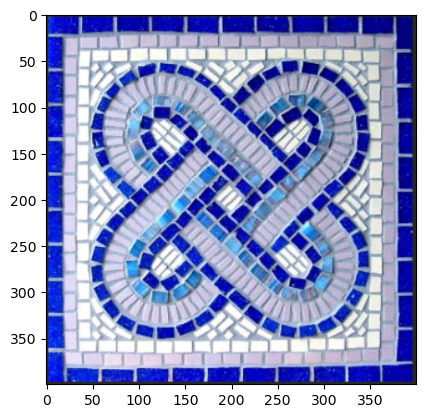

In [ ]:
# import data and test compute_style_cost
# TODO later/ verify style cost

# Syle imge reading and preprocessing
img_size = 400

# Style image initialization
style_img_path = os.path.join('.','Neural-Style-Transfer-with-Python/style imgs/abstract mosaic art style.PNG')

style_image =  cv2.resize(cv2.imread(style_img_path), (img_size, img_size))
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
style_image_rgb = cv2.cvtColor(style_image[0].numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(style_image_rgb)
#plt.show()


In [ ]:
"""import PIL.Image as Image
c = np.array(Image.open("/content/Cat03.jpg").resize((img_size, img_size)))
print(c[20 ,20])"""

'import PIL.Image as Image\nc = np.array(Image.open("/content/Cat03.jpg").resize((img_size, img_size)))\nprint(c[20 ,20])'

(400, 400, 3)
(400, 400, 3)
tf.Tensor([224 238 244], shape=(3,), dtype=uint8)


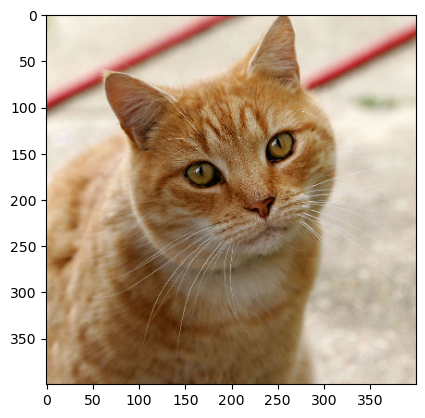

In [ ]:
# content image initialization
content_img_path = os.path.join('.','Neural-Style-Transfer-with-Python','content imgs', 'Cat03.jpg')
content_image =  cv2.resize(cv2.imread(content_img_path), (img_size, img_size))
print(content_image.shape)
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

# display purposes only
content_image_rgb = cv2.cvtColor(content_image[0].numpy(), cv2.COLOR_BGR2RGB)
print(content_image_rgb.shape)
print(content_image[0, 20 ,20])
plt.imshow(content_image_rgb)

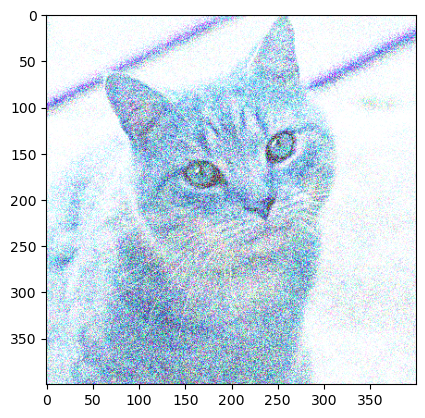

In [ ]:
# initialize and preprocess generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image_preprocessed = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image_preprocessed = tf.Variable(generated_image_preprocessed, tf.float32)
plt.imshow(generated_image_preprocessed[0].numpy())


In [ ]:
# preprocess style and content images
content_img_preprocessed = tf.image.convert_image_dtype(content_image, tf.float32)
style_img_preprocessed = tf.image.convert_image_dtype(style_image, tf.float32)

In [ ]:
vgg_input_shape = (400, 400, 3)
model = VGG19(input_shape = vgg_input_shape, include_top= False, weights = 'imagenet')
model.trainable = False

In [ ]:
# initiaalize models
c_m = create_content_model(model = model, layer_name = 'block2_conv2', layer_index = None)

layer_names = layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                             'block4_conv1', 'block5_conv1']
s_m = create_style_model(model = model, layer_names = layer_names)
# initialize activations
a_c = c_m(content_img_preprocessed)
a_s = s_m(style_img_preprocessed)

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
#s_m.summary()
print(len(s_m(generated_image_preprocessed)))
print(s_m.output_shape)
print(len(a_s))

5
[(None, 400, 400, 64), (None, 200, 200, 128), (None, 100, 100, 256), (None, 50, 50, 512), (None, 25, 25, 512)]
5


In [ ]:
beg = time.time()
for i in range(15000):

    with tf.GradientTape() as tape:
        # generated activations here generated_img
        a_g = c_m(generated_image_preprocessed)
        content_cost = compute_content_cost(a_c, a_g)

        a_g = s_m(generated_image_preprocessed)
        style_cost = compute_style_cost(a_s, a_g, layer_weights = None)

        cost = compute_total_cost(content_cost, style_cost, alpha = 100, beta = 100)
        #print(f'--Cost = {float(cost.numpy())}', end =' ')


    grads = tape.gradient(cost, generated_image_preprocessed)
    optimizer.apply_gradients([(grads, generated_image_preprocessed)])
    if i % 1000 == 0:

        print(f'Epoch : {i} -- Cost = {float(cost.numpy())}')
    # add 0_1 clipping here
    generated_image_preprocessed.assign(clip_0_1(generated_image_preprocessed))

# bgr display
plt.imshow(generated_image_preprocessed[0].numpy())
end = time.time()
print(f'Compute time {end - beg} s')

In [ ]:
# rgb display
plt.imshow(generated_image_preprocessed[0].numpy()[..., ::-1])